# Avaliação 1
___
## Modelo de RNA com dados de potência elétrica

Requisitos:
* Erro Percentual Absoluto Máximo menor que 10%
* Erro Percentual Absoluto Médio menor que 3%

**Disciplina:** Automação Inteligênte

**Autor:** Miguel Marques Ferreira

**GitHub:** https://github.com/Miguel-mmf

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update(
    {
        'figure.figsize':(16,5),
        'figure.facecolor':'white',
        # 'font.size':'12',
        'axes.grid': True,
        'axes.grid.axis': 'both',
        # 'text.usetex' : True,
        # 'font.family' : 'serif',
        # 'font.serif' : 'cm'
    }
)

from sklearn.preprocessing import MinMaxScaler
from distutils.dir_util import mkpath
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    max_error
)
from sklearn.model_selection import train_test_split
from kerastuner import Objective
from kerastuner.tuners import RandomSearch

%matplotlib inline

2024-02-18 23:56:55.394477: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 23:56:55.672548: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 23:56:55.672589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 23:56:55.674533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 23:56:55.757345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 23:56:55.758419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Funções de apoio

In [2]:
def scale_data(df, scalers=None, scaler_type='minmax'):
    """
    Scales a dataset using either MinMaxScaler, StandardScaler or QuantileTransformer from scikit-learn.

    Parameters:
    df (pandas.DataFrame): The dataset to be scaled.
    scaler_type (str): The type of scaler to use. Either 'minmax', 'standard' or 'quantile'.

    Test:
    for s in scalers.values():
        print(s.get_params(True), end=' | ')
        print(s.data_min_, end=' | ')
        print(s.data_max_)

    Returns:
    pandas.DataFrame: The scaled dataset.
    dict: A scalers dict.
    """

    df_norm = pd.DataFrame()

    if scalers:

        for col in df.columns:
            feat = np.array(df[col])
            aux = feat.shape
            data = scalers[col].transform(feat.reshape(-1,1)) # f.transform(feat)
            df_norm[col] = data.reshape(aux)

        return df_norm

    else: # shift nas linhas abaixo

        scalers = dict()
        for col in df.columns:

            if scaler_type == 'minmax':
                scaler = MinMaxScaler(feature_range=(0.15,0.85)) # default
            # elif scaler_type == 'standard':
            #     scaler = StandardScaler()
            # elif scaler_type == 'quantile':
            #     scaler = QuantileTransformer()
            else:
                raise ValueError("Invalid scaler type. Must be 'minmax', 'standard' or 'quantile'.")

            scalers[col] = scaler
            feat = np.array(df[col])
            aux = feat.shape
            data = scalers[col].fit_transform(feat.reshape(-1,1)) # f.transform(feat)
            df_norm[col] = data.reshape(aux)

        return df_norm, scalers

In [3]:
def difference_plot(
        real_data,
        predicted_data,
        xy_labels={
            'x': 'Pontos',
            'y': 'Potência (MW)'
        },
        legends={
            'ax0': ['Potência Real','Potência Estimada'],
            'ax1': ['Diferença entre Potência Real e Estimada']
        },
        filename=' ',
        save=False,
        formats=['eps', 'png', 'pdf'],
        return_fig=False
    ):
    """This function creates a figure with two subplots: the first one shows the real and predicted data, and the second one shows the difference between the real and predicted data.

    Args:
        real_data (Series): A series with the real data.
        predicted_data (Series): A series with the predicted data.
        xy_labels (dict, optional): _description_. Defaults to { 'x': 'Pontos', 'y': 'Potência (MW)' }.
        legends (dict, optional): _description_. Defaults to { 'ax0': ['Potência Real','Potência Estimada'], 'ax1': ['Diferença entre Potência Real e Estimada'] }.
        filename (str, optional): _description_. Defaults to ' '.
        save (bool, optional): _description_. Defaults to False.
        formats (list, optional): _description_. Defaults to ['eps', 'png', 'pdf'].
        return_fig (bool, optional): _description_. Defaults to False.

    Returns:
        matplotlib.figure.Figure: A figure with two subplots.
    """

    fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=600, sharex=True)

    axs[0].plot(real_data, lw=2, color='Red', marker='s', markersize=3)
    axs[0].plot(predicted_data, lw=2, color='Blue')

    axs[1].plot(real_data - predicted_data, lw=2, color='red')
    axs[1].fill_between(
        range(0, len(predicted_data)),
        (real_data - predicted_data).ravel(),
        lw=2,
        color='red',
        alpha=0.5
    )

    for i in range(2):
        axs[i].grid(True)
        axs[i].set_ylabel(xy_labels['y'])
        axs[i].set_xlabel(xy_labels['x'])
        axs[i].legend(legends[f'ax{i}'])

    plt.tight_layout()

    if save:
        if filename == ' ':
            f = './figures/difference_plot'
        else:
            mkpath('/'.join(filename.split('/')[:-1]))
            f = filename

        for format in formats:
            plt.savefig(f'{f}.{format}', format=format, dpi=600)


    if return_fig:
        return fig, axs
    else:
        plt.show()

In [4]:
def create_mae_mse_rmse_figures(df_history, save=False, filename=' ', return_fig=False):
    """This function creates the MAE, MSE and RMSE figures for the training and validation sets.

    Args:
        df_history (DataFrame): The history of the training and validation sets.
        save (bool, optional): The flag to save the figures. Defaults to False.
        filename (str, optional): The filename to save the figures. Defaults to ' '.
    """

    cols = df_history.columns
    length_df_history = len(df_history)
    metrics = {
        'mae': 'mean_absolute_error',
        'mse': 'mean_squared_error',
        'rmse': 'root_mean_squared_error',
        # 'mape': 'mean_absolute_percentage_error',
    }

    figs = list()
    axss = list()

    for key, value in metrics.items():
        
        fig, axs = plt.subplots(1,1,figsize=(12,5),dpi=600)
        
        if key in cols:
            axs.plot(df_history[key],lw=2,color='red', label=f'Training {key.upper()}')
            axs.plot(df_history[f'val_{key}'],lw=2,color='blue', label=f'Validation {key.upper()}')
        else:
            try:
                axs.plot(df_history[value],lw=2,color='red', label=f'Training {key.upper()}')
                axs.plot(df_history[f'val_{value}'],lw=2,color='blue', label=f'Validation {key.upper()}')
            except Exception as e:
                print(e)

        axs.grid(True)
        axs.set_ylabel(key.upper(), fontsize=22)
        axs.set_xlabel('Epochs', fontsize=22)
        axs.set_xlim([0, length_df_history+1])
        # axs.set_xticks([i for i in range(0,length_df_history,2)], fontsize=20)
        axs.legend(fontsize=18)
        axs.grid(visible=True)

        figs.append(fig)
        axss.append(axs)
        
        if save:
            if filename == ' ':
                f = key.upper()
            else:
                f = filename + '_' + key.upper()
            #plt.savefig(f'{filename}.eps', format='eps', dpi=600)
            plt.savefig(f'{f}.png', format='png', dpi=600)
            #plt.savefig(f'{filename}.pdf', format='pdf', dpi=600) 

    if save:
        if filename == ' ':
            f = 'history.csv'
        else:
            f = filename + 'history.csv'

        df_history.to_csv(f)

    if return_fig:
        return figs, axss

In [5]:
def max_absolute_percentage_error(y_true, y_pred):

    # errors = list()
    y_pred = y_pred.to_numpy().reshape(1, -1)
    y_true = y_true.to_numpy().reshape(1, -1)
    epsilon = np.finfo(np.float64).eps
    max_ape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    max_ape = np.max(max_ape)

    return max_ape

In [18]:
def build_MLP_model(hp, input_shape=(7), output_shape=(2), n_layers=3, name='MLP_Model'):

    model = tf.keras.Sequential(name=name)

    model.add(
        tf.keras.layers.Dense(
            units = hp.Int('units', min_value=1, max_value=100, step=1),
            activation = hp.Choice('activation', values=['relu','sigmoid']),
            input_shape=(input_shape,)
        )
    )

    # Number of layers of the MLP is a hyperparameter.
    for i in range(hp.Int("mlp_layers", 0, n_layers)):
        model.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"units_{i}", min_value=1, max_value=100, step=1),
                activation = hp.Choice('activation', values=['relu','sigmoid'])
            )
        )

    model.add(tf.keras.layers.Dense(units=output_shape, activation = 'sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate= hp.Float("lr", min_value=1e-6, max_value=1e-1, sampling="log")
        ),
        loss='mse',
        metrics=[
            'mae',
            'mse',
            tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
        ]
    )

    return model

## Leitura dos dados de treinamento, validação e teste

In [9]:
!ls automacao_inteligente/data

x_test.csv  x_train.csv  x_valid.csv  y_test.csv  y_train.csv  y_valid.csv


In [63]:
x_train = pd.read_csv('automacao_inteligente/data/rna1/x_train.csv', index_col=0)
y_train = pd.read_csv('automacao_inteligente/data/rna1/y_train.csv', index_col=0)

x_valid = pd.read_csv('automacao_inteligente/data/rna1/x_valid.csv', index_col=0)
y_valid = pd.read_csv('automacao_inteligente/data/rna1/y_valid.csv', index_col=0)

x_test = pd.read_csv('automacao_inteligente/data/rna1/x_test.csv', index_col=0)
y_test = pd.read_csv('automacao_inteligente/data/rna1/y_test.csv', index_col=0)

In [64]:
x_train_scaled, x_scalers = scale_data(x_train, scaler_type='minmax')
y_train_scaled, y_scalers = scale_data(y_train, scaler_type='minmax')

x_valid_scaled = scale_data(x_valid, x_scalers)
y_valid_scaled = scale_data(y_valid, y_scalers)

x_test_scaled = scale_data(x_test, x_scalers)
y_test_scaled = scale_data(y_test, y_scalers)

In [65]:
print(f'Shape x_train: {x_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape x_valid: {x_valid.shape}')
print(f'Shape y_valid: {y_valid.shape}')
print(f'Shape x_test: {x_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape x_train: (215, 10)
Shape y_train: (215, 2)
Shape x_valid: (46, 10)
Shape y_valid: (46, 2)
Shape x_test: (47, 10)
Shape y_test: (47, 2)


## RandomSearch com o KerasTuner

In [156]:
!rm -rf results

In [157]:
tuner = RandomSearch(
    build_MLP_model,
    objective=Objective("mse", direction="min"),
    max_trials=30,
    executions_per_trial=2,
    directory='./results',
    project_name='mlp'
)

In [158]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
mlp_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [159]:
tuner.search(
    x_train_scaled,
    y_train_scaled,
    epochs=200,
    # batch_size=20,
    # validation_data=(x_valid_scaled, y_valid_scaled)
)

Trial 30 Complete [00h 00m 17s]
mse: 0.04295150190591812

Best mse So Far: 0.004059122409671545
Total elapsed time: 00h 09m 36s


In [160]:
models = tuner.get_best_models(3)
tuner.results_summary(3)

Results summary
Results in ./results/mlp
Showing 3 best trials
Objective(name="mse", direction="min")

Trial 15 summary
Hyperparameters:
units: 63
activation: relu
mlp_layers: 1
units_0: 56
lr: 0.019395556611655537
units_1: 43
units_2: 95
Score: 0.004059122409671545

Trial 17 summary
Hyperparameters:
units: 90
activation: relu
mlp_layers: 1
units_0: 95
lr: 0.002124182652188752
units_1: 69
units_2: 37
Score: 0.0042046725284308195

Trial 14 summary
Hyperparameters:
units: 41
activation: sigmoid
mlp_layers: 2
units_0: 52
lr: 0.08819543663083977
units_1: 20
units_2: 88
Score: 0.0042275055311620235


In [161]:
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=x_train_scaled.shape[1])
best_model.summary()

Model: "MLP_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 63)                504       
                                                                 
 dense_1 (Dense)             (None, 56)                3584      
                                                                 
 dense_2 (Dense)             (None, 2)                 114       
                                                                 
Total params: 4202 (16.41 KB)
Trainable params: 4202 (16.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


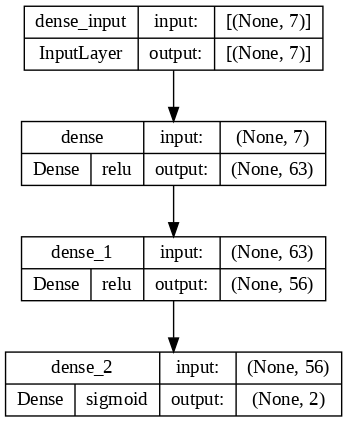

In [162]:
tf.keras.utils.plot_model(
    best_model,
    "./results/mlp/best_model_TB.png",
    show_shapes=True,
    rankdir="TB", # a string specifying the format of the plot: 'TB' creates a vertical plot; 'LR' creates a horizontal plot.
    dpi=100,
    show_layer_activations=True,
)

### Retreinando o melhor modelo

In [179]:
# Get the top 2 hyperparameters.
tf.keras.backend.clear_session()
best_hps = tuner.get_best_hyperparameters(5)
# Build the model_tuner with the best hp.
model_tuner = build_MLP_model(best_hps[1])

history = model_tuner.fit(
    x_train_scaled,
    y_train_scaled,
    epochs=500,
    # batch_size=20,
    # validation_data=(x_valid_scaled,y_valid_scaled),
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=0.000001)]
)

test_scores = model_tuner.evaluate(
    x=x_test_scaled,
    y=y_test_scaled,
    verbose=0
)

print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/500
8/8 [==============================] - 1s 3ms/step - loss: 0.0274 - mae: 0.1357 - mse: 0.0274 - root_mean_squared_error: 0.1656 - mean_absolute_percentage_error: 28.3587
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0205 - mae: 0.1153 - mse: 0.0205 - root_mean_squared_error: 0.1433 - mean_absolute_percentage_error: 27.8419
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0191 - mae: 0.1127 - mse: 0.0191 - root_mean_squared_error: 0.1383 - mean_absolute_percentage_error: 26.5168
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0178 - mae: 0.1093 - mse: 0.0178 - root_mean_squared_error: 0.1333 - mean_absolute_percentage_error: 25.4444
Epoch 5/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0162 - mae: 0.1047 - mse: 0.0162 - root_mean_squared_error: 0.1274 - mean_absolute_percentage_error: 24.1066
Epoch 6/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0143 - mae: 0.098

In [180]:
history = pd.DataFrame(history.history)
history.head()

,loss,mae,mse,root_mean_squared_error,mean_absolute_percentage_error
0,0.027408,0.135692,0.027408,0.165554,28.358711
1,0.020539,0.115259,0.020539,0.143313,27.841862
2,0.019123,0.112688,0.019123,0.138287,26.516850
3,0.017777,0.109308,0.017777,0.133331,25.444372
4,0.016226,0.104696,0.016226,0.127381,24.106573


Text(0.5, 0, 'Epoch')

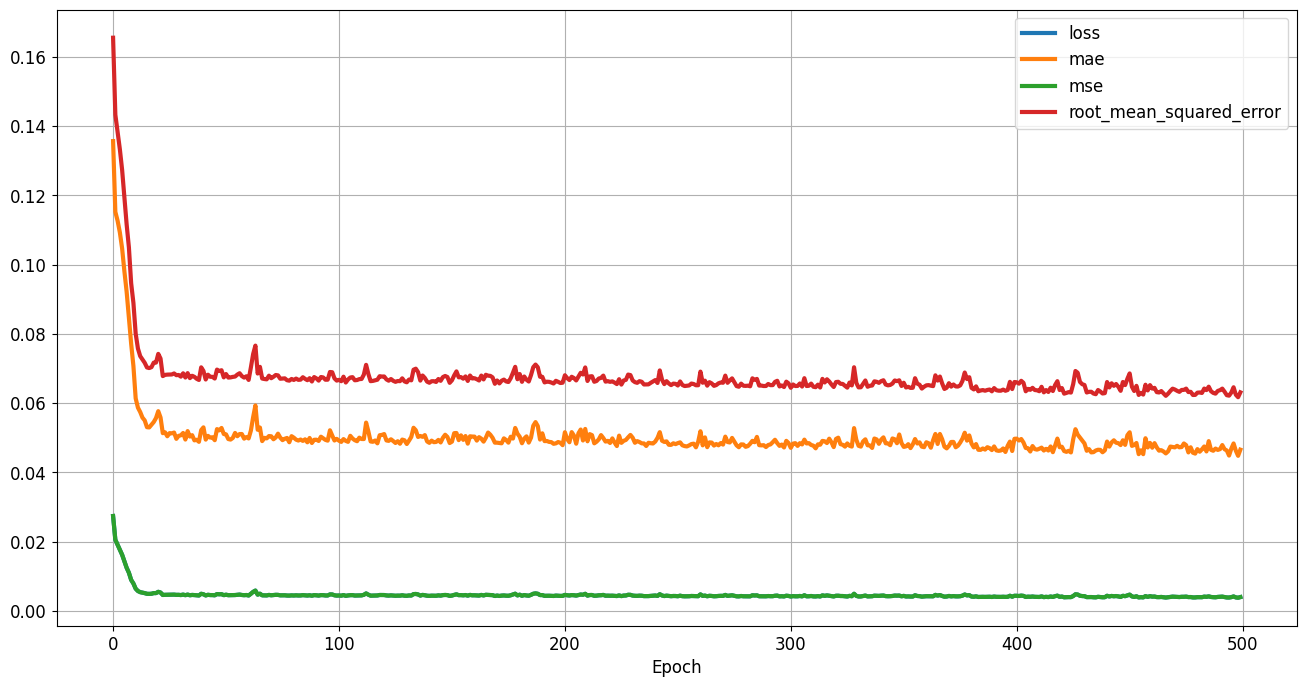

In [181]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
for col in history.columns[:-1]:
    ax.plot(history[col], lw=3, label=col)
ax.legend()
plt.grid(True)
plt.xlabel('Epoch')
# plt.ylabel('Potência (MW)')
# plt.title('Potência Média por Horário')

### Avaliação do conjunto de teste

In [184]:
for name, metric in zip(['loss','mae','mse'],model_tuner.evaluate(x_test_scaled,y_test_scaled)): print(f'{name}:{metric}')

2/2 [==============================] - 0s 7ms/step - loss: 0.0023 - mae: 0.0383 - mse: 0.0023 - root_mean_squared_error: 0.0478 - mean_absolute_percentage_error: 7.7943
loss:0.0022814441472291946
mae:0.038326676934957504
mse:0.0022814441472291946


In [185]:
# df_real_previsto = y_test # pd.DataFrame()
# df_real_previsto['real K+1'] = y_test[:,0]
# df_real_previsto['real K+2'] = y_test[:,1]
# df_real_previsto.reset_index(inplace=True)
# df_real_previsto.drop(columns=['index','level_0'], inplace=True, errors='ignore')
df_real_previsto.head()

,POTENCIA(K+1),POTENCIA(K+2),previsto K+1,previsto K+2,previsto K+1 - RandomSearch,previsto K+2 - RandomSearch
0,18.6,18.100000,18.719004,18.760086,18.354494,18.082317
1,16.4,16.400000,17.870964,17.937851,17.249454,17.187061
2,17.1,17.200001,16.662363,16.792484,16.587751,16.790987
3,18.1,18.100000,18.001644,18.080278,17.784786,17.364389
4,13.1,13.400000,14.224337,14.459863,14.949124,14.934766


In [186]:
y_predicted = model_tuner.predict(x_test_scaled)
y_predicted.shape

2/2 [==============================] - 0s 7ms/step


(62, 2)

In [187]:
df_real_previsto['previsto K+1 - RandomSearch'] = y_scalers['POTENCIA(K+1)'].inverse_transform(y_predicted[:,0].reshape(-1, 1))
df_real_previsto['previsto K+2 - RandomSearch'] = y_scalers['POTENCIA(K+2)'].inverse_transform(y_predicted[:,1].reshape(-1, 1))

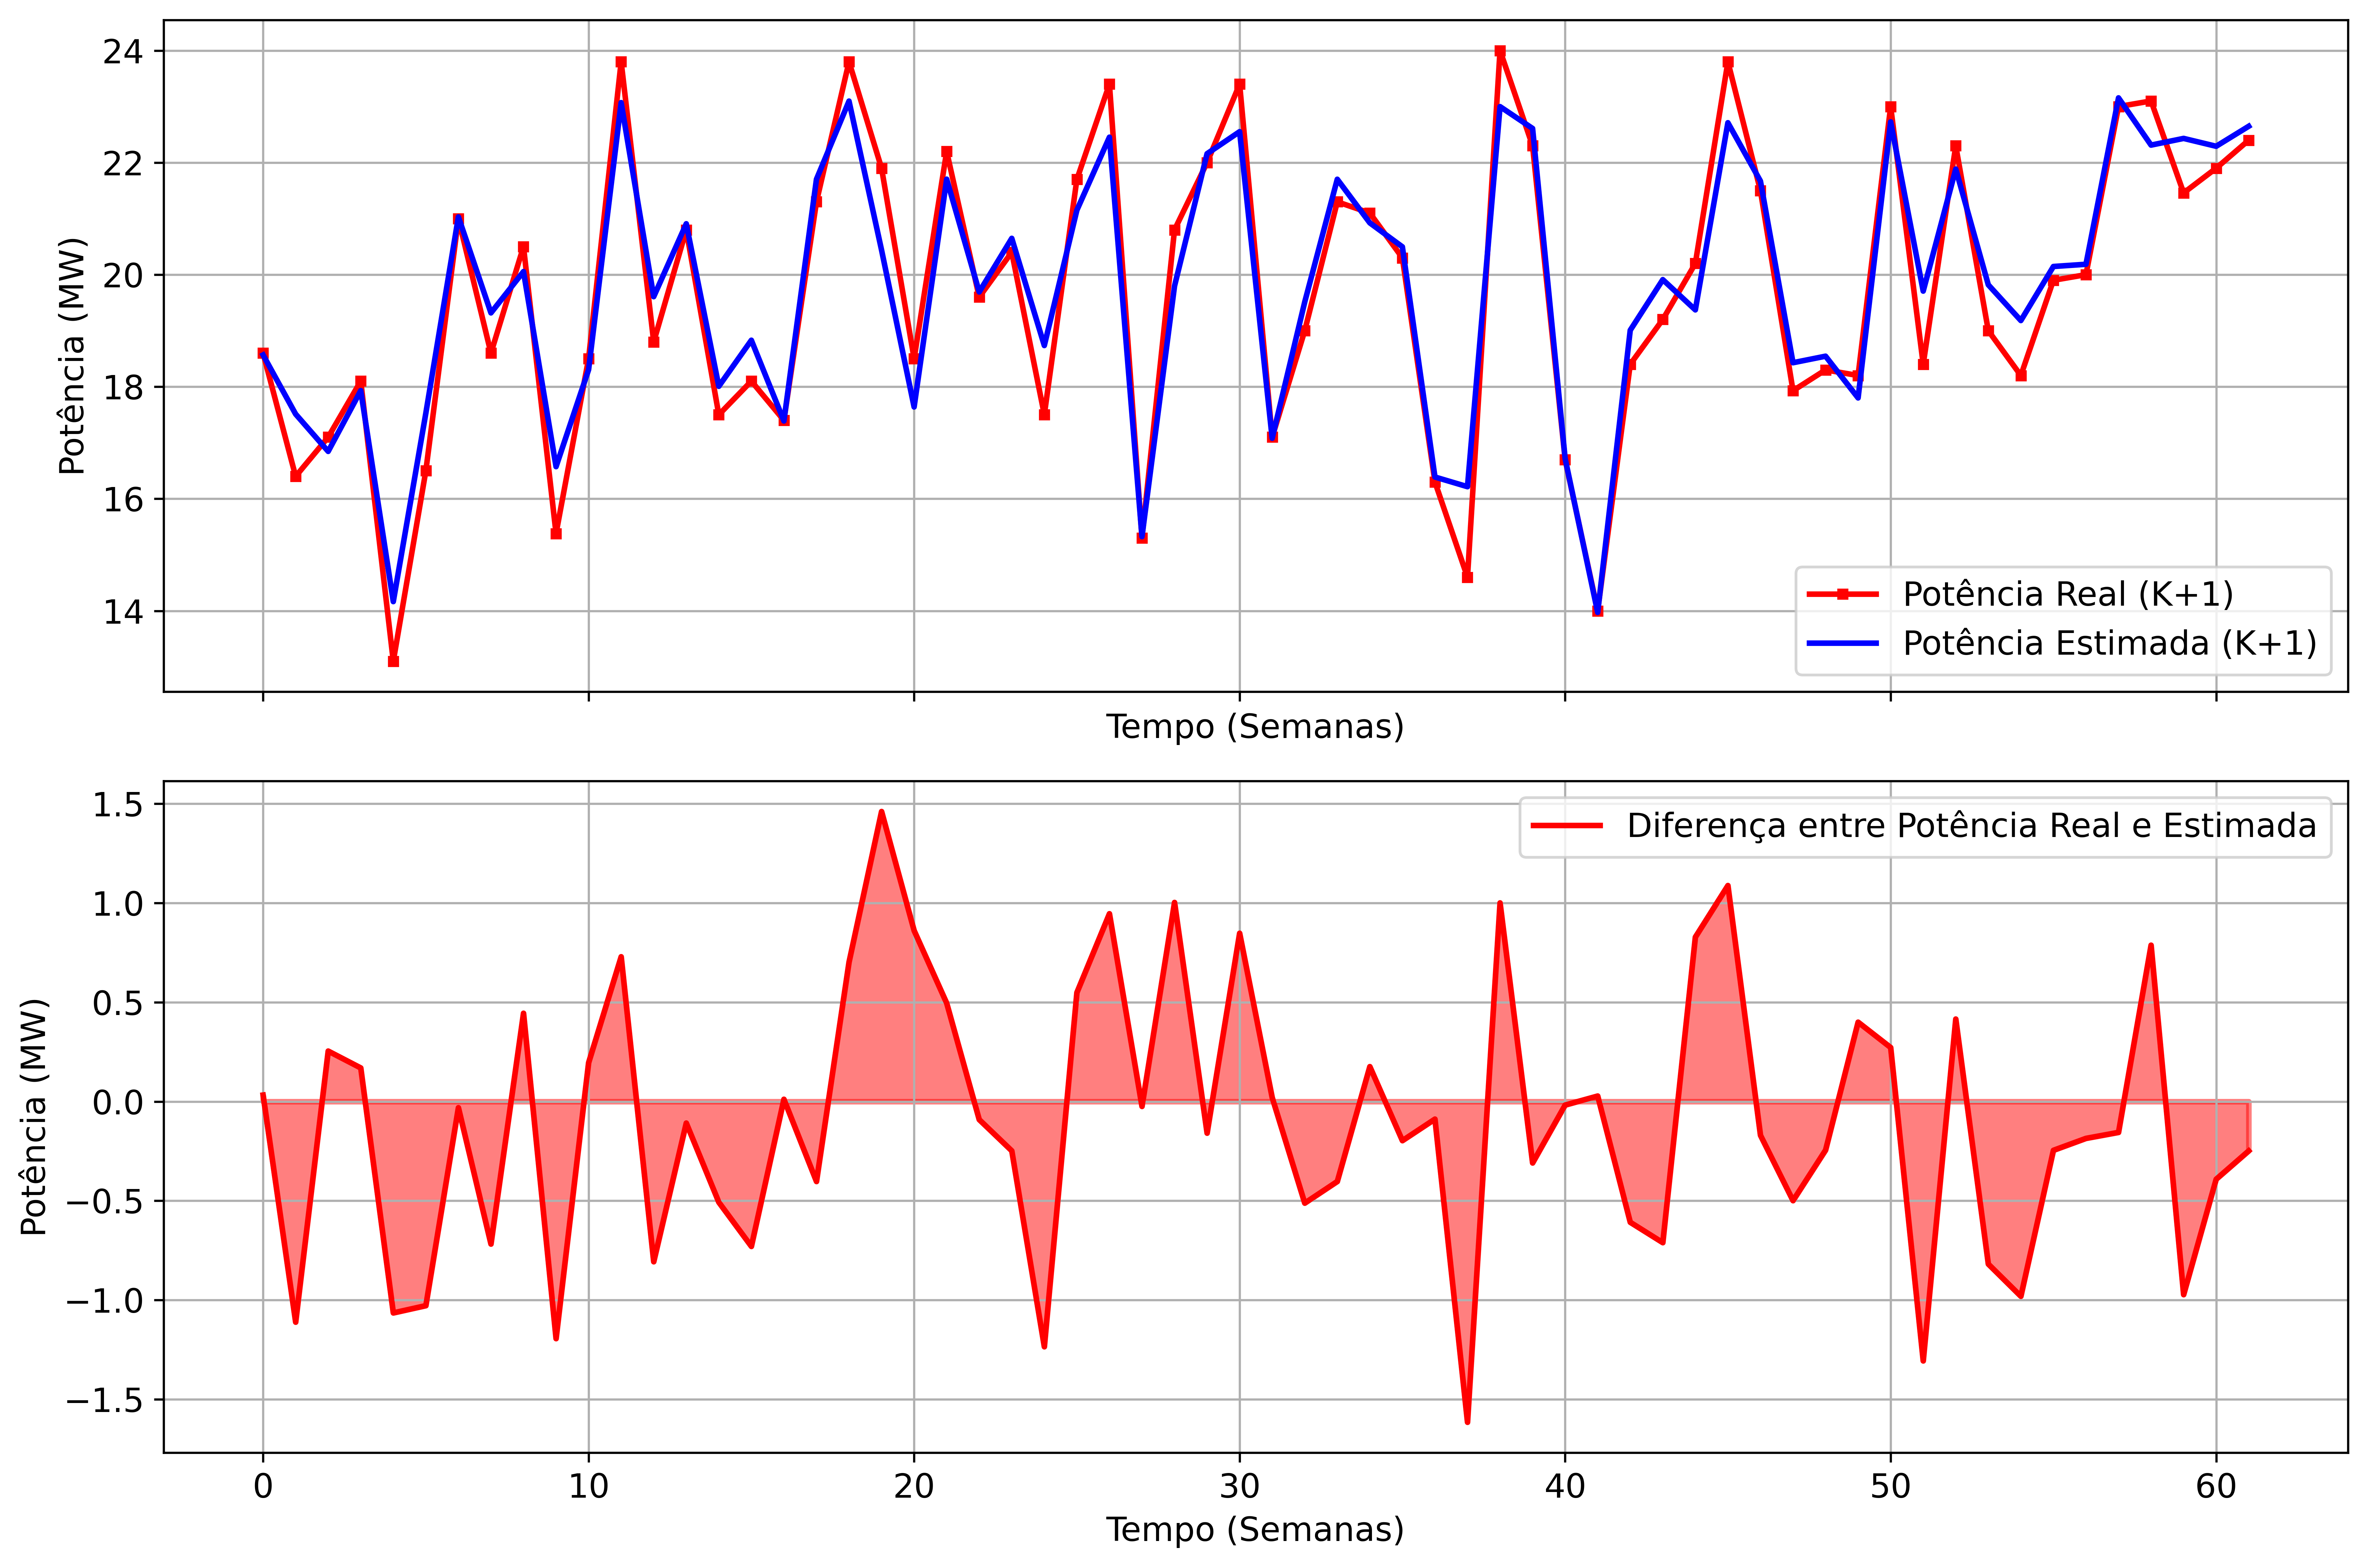

In [188]:
difference_plot(
    real_data=df_real_previsto['POTENCIA(K+1)'],
    predicted_data=df_real_previsto['previsto K+1 - RandomSearch'],
    xy_labels={
        'x': 'Tempo (Semanas)',
        'y': 'Potência (MW)'
    },
    legends={
            'ax0': ['Potência Real (K+1)','Potência Estimada (K+1)'],
            'ax1': ['Diferença entre Potência Real e Estimada']
        },
    filename='./difference_plot.png',
    save=False,
    formats=['png'],
    return_fig=False
)

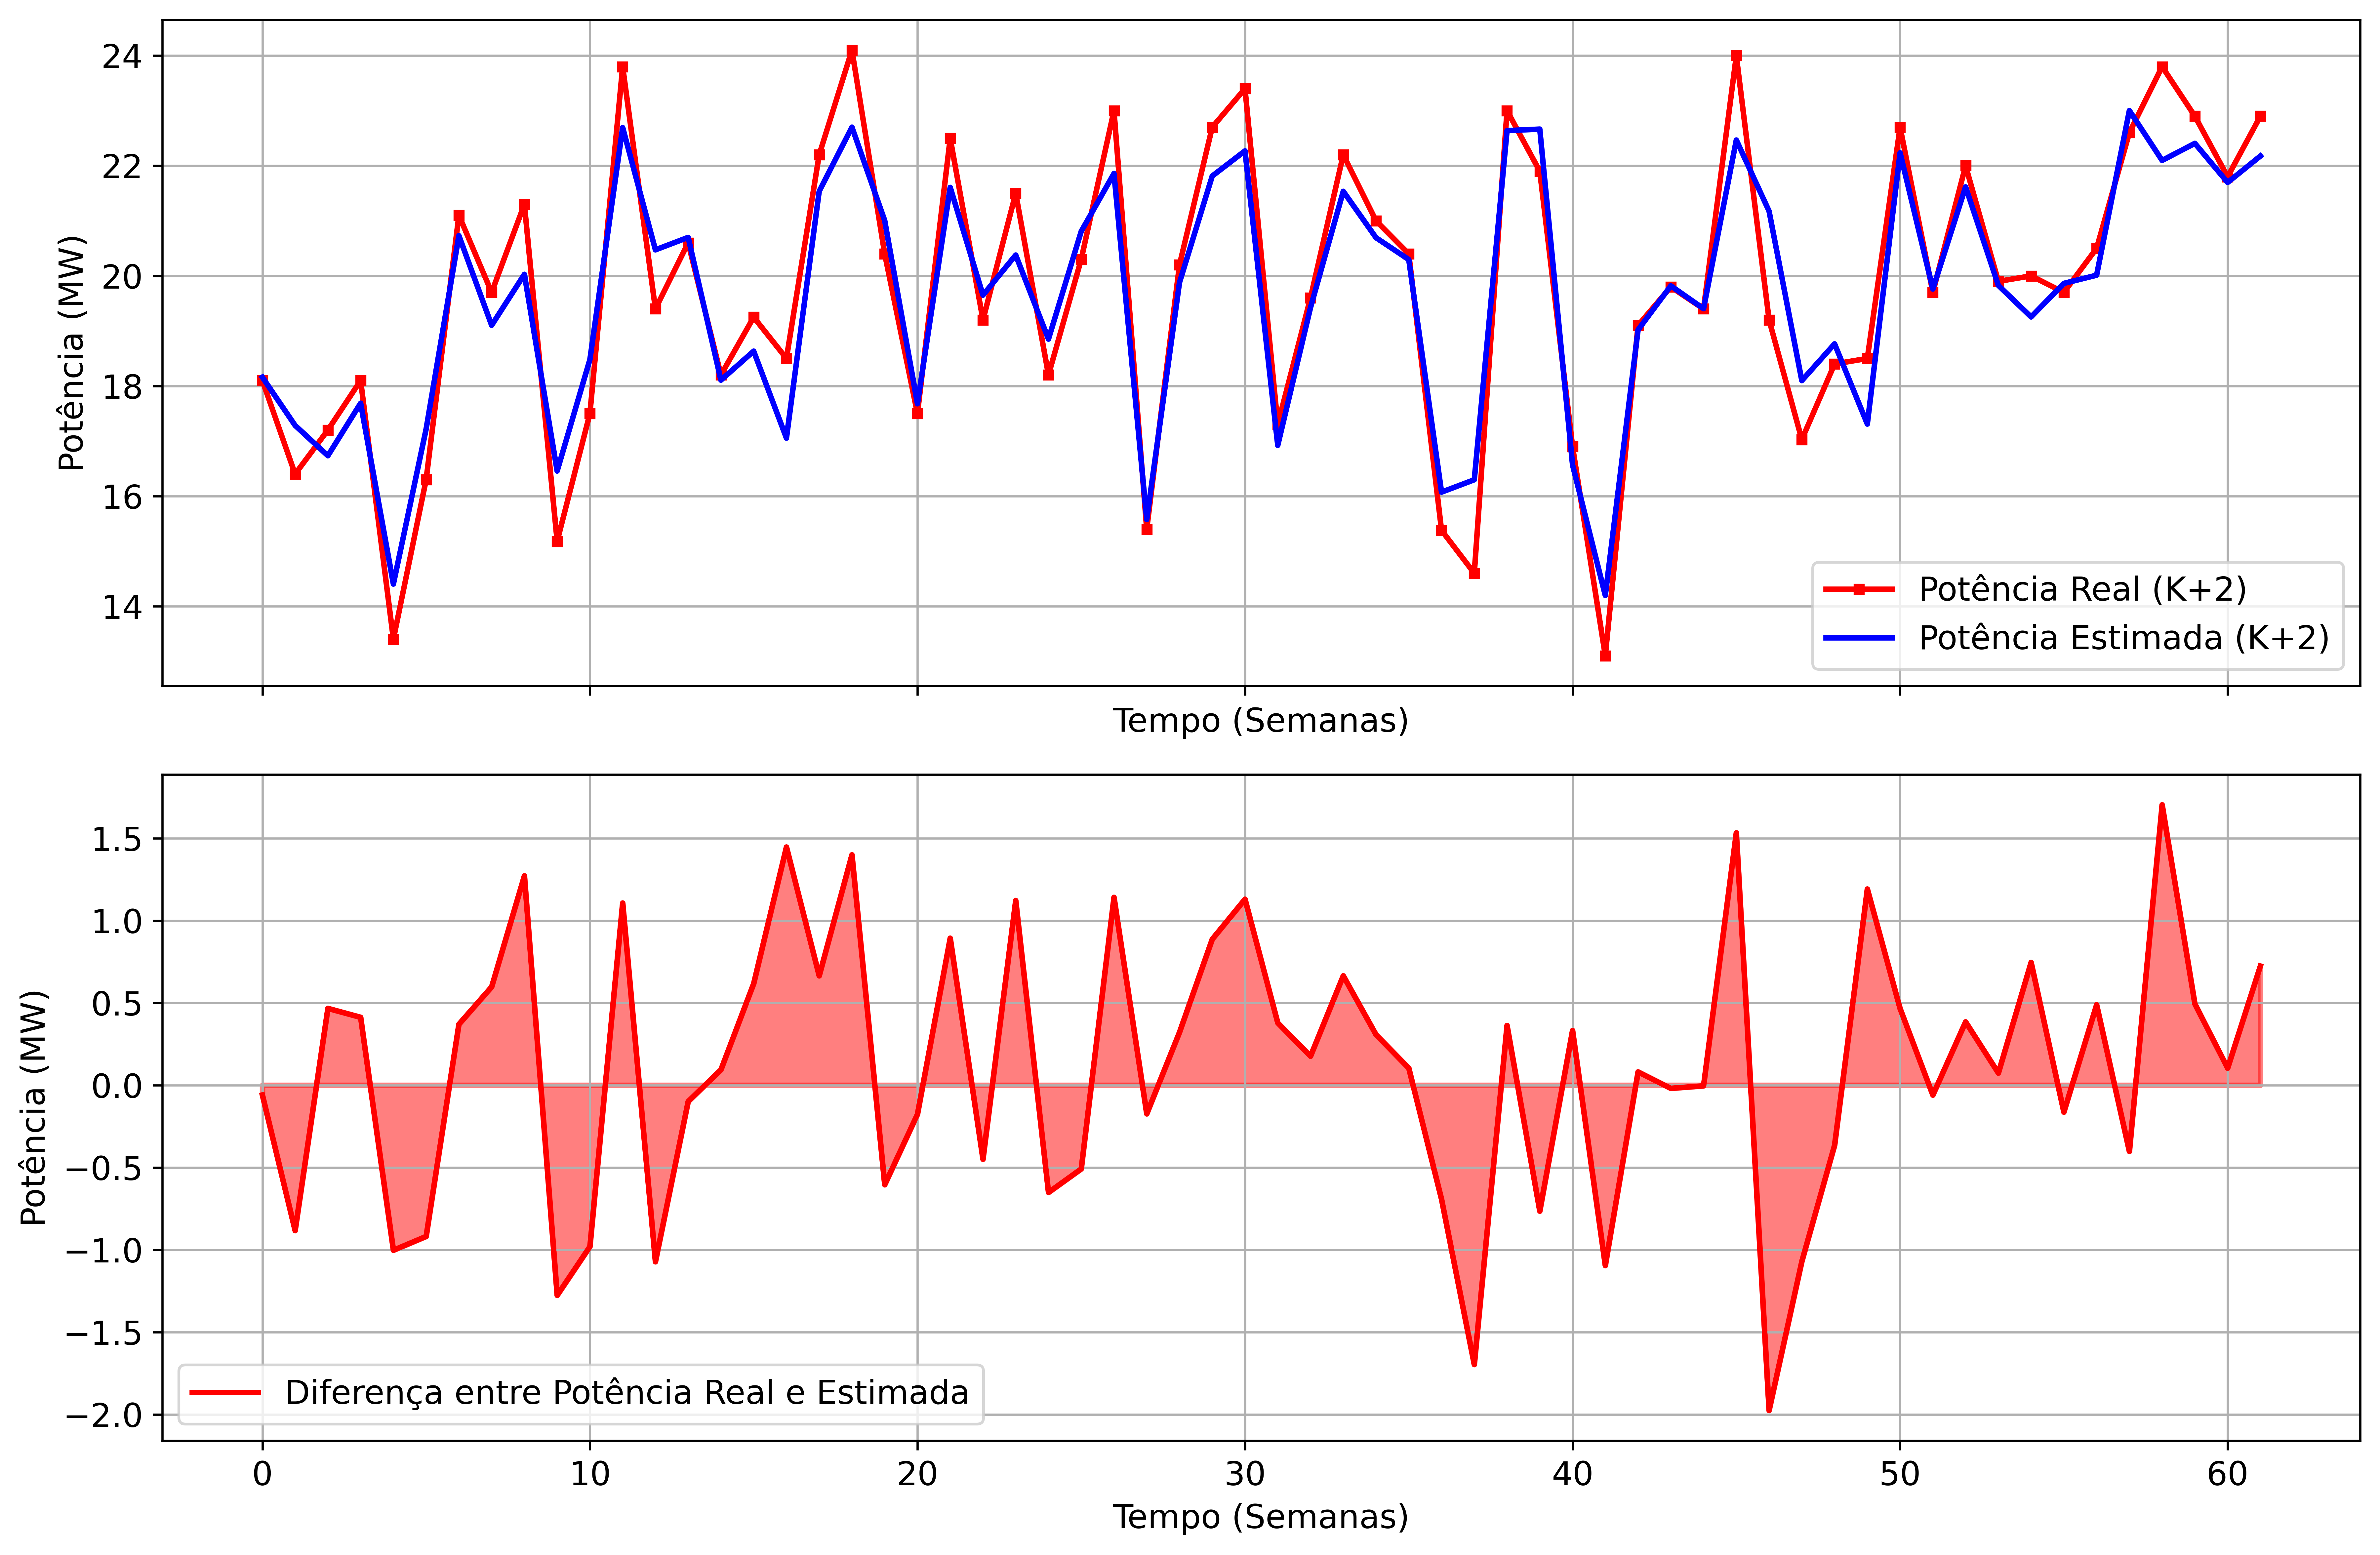

In [189]:
difference_plot(
    real_data=df_real_previsto['POTENCIA(K+2)'],
    predicted_data=df_real_previsto['previsto K+2 - RandomSearch'],
    xy_labels={
        'x': 'Tempo (Semanas)',
        'y': 'Potência (MW)'
    },
    legends={
            'ax0': ['Potência Real (K+2)','Potência Estimada (K+2)'],
            'ax1': ['Diferença entre Potência Real e Estimada']
        },
    filename='./difference_plot.png',
    save=False,
    formats=['png'],
    return_fig=False
)

### Métricas de avaliação

#### K+1

In [190]:
print(f"MAE: {mean_absolute_error(df_real_previsto['POTENCIA(K+1)'],df_real_previsto['previsto K+1 - RandomSearch'])}")
print(f"MSE: {mean_squared_error(df_real_previsto['POTENCIA(K+1)'],df_real_previsto['previsto K+1 - RandomSearch'])}")
print(f"RMSE: {np.sqrt(mean_squared_error(df_real_previsto['POTENCIA(K+1)'],df_real_previsto['previsto K+1 - RandomSearch']))}")
print(f"MAXE: {max_error(df_real_previsto['POTENCIA(K+1)'],df_real_previsto['previsto K+1 - RandomSearch'])}")
print(f"MAPE: {mean_absolute_percentage_error(df_real_previsto['POTENCIA(K+1)'],df_real_previsto['previsto K+1 - RandomSearch'])*100}")
print(f"Max_APE: {max_absolute_percentage_error(df_real_previsto['POTENCIA(K+1)'],df_real_previsto['previsto K+1 - RandomSearch'])*100}")

MAE: 0.5462133205278557
MSE: 0.4669604608985467
RMSE: 0.6833450525895002
MAXE: 1.6157665267382804
MAPE: 2.8541652505470383
Max_APE: 11.066893730712906


#### K+2

In [191]:
print(f"MAE: {mean_absolute_error(df_real_previsto['POTENCIA(K+2)'],df_real_previsto['previsto K+2 - RandomSearch'])}")
print(f"MSE: {mean_squared_error(df_real_previsto['POTENCIA(K+2)'],df_real_previsto['previsto K+2 - RandomSearch'])}")
print(f"RMSE: {np.sqrt(mean_squared_error(df_real_previsto['POTENCIA(K+2)'],df_real_previsto['previsto K+2 - RandomSearch']))}")
print(f"MAXE: {max_error(df_real_previsto['POTENCIA(K+2)'],df_real_previsto['previsto K+2 - RandomSearch'])}")
print(f"MAPE: {mean_absolute_percentage_error(df_real_previsto['POTENCIA(K+2)'],df_real_previsto['previsto K+2 - RandomSearch'])*100}")
print(f"Max_APE: {max_absolute_percentage_error(df_real_previsto['POTENCIA(K+1)'],df_real_previsto['previsto K+1 - RandomSearch'])*100}")

MAE: 0.6680930676448698
MSE: 0.6763216415681533
RMSE: 0.8223877683721672
MAXE: 1.9760246306249982
MAPE: 3.471883128311463
Max_APE: 11.066893730712906
